In [93]:
import numpy as np
import scipy as sp
import scipy.io
import mmap
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from ipywidgets import interact
from os import path
from quimb import *

In [94]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [138]:
r=2
scratch = 'spin_data/'
wf_dir = 'spin_wf/'

def wf_reader(L,Na,dN,integrable):
#     if L==10:
#         st_num =50
#     elif L==18:
#         st_num = 7300

    Nb = L-Na
    dims_a = [r] * Na
    dims = [r] * L
    N = prod(dims)
    neg_q=np.zeros((int(Na/2)+1,2*dN))

    if integrable==True:
        fname=scratch+ "Z2_L%d_integrable_P0.txt" % (L) # newest Z3 afm
    else:
        fname=scratch+ "Z2_L%d_chaotic_P0.txt" % (L) # newest Z3 afm

    fname_read=open(fname)
    fname_ptr=mmap.mmap(fname_read.fileno(), 0, access=mmap.ACCESS_READ)

    lst=r**np.arange(L-1,-1,-1)

    BOFbasis=b"Basis:"
    B1=fname_ptr.find(BOFbasis)+1
    EOFbasis=b"}"
    Eb=fname_ptr.find(EOFbasis)-20
    
    s=(fname_ptr[B1+8:Eb+19]) 
    s=s.replace(b'> |', b'')
    s=s.replace(b'|', b'')
    s=s.replace(b'+ translations', b'')        
    s=s.replace(b'>', b'')
    s=s.replace(b']', b'')
    s=s.replace(b'*', b'')
    vec_list=s.split(b'\n')

    vec_txt=b"Eigenvector# 0:"
    va1=fname_ptr.find(vec_txt)
    va2=va1+fname_ptr[va1:].find(b'[')
    va3=va2+fname_ptr[va2:].find(b']')

    gs_wf = list(map(float,fname_ptr[va2+1:va3].split(b",")))
    vec_size=len(gs_wf)
    print('No. of states:', vec_size)
    states=np.arange(vec_size/2-dN,vec_size/2+dN)

    t_timer=time.time()

    for i_s in range(len(states)):
        st_num=states[i_s]
        print('state #%d was read' % (st_num))
        vec_txt=b"Eigenvector# %d:" % (st_num)
        va1=fname_ptr.find(vec_txt)
        va2=va1+fname_ptr[va1:].find(b'[')
        va3=va2+fname_ptr[va2:].find(b']')

        t_timer=time.time()

        gs_wf = list(map(float,fname_ptr[va2+1:va3].split(b",")))

        evec_ind=np.zeros((r**L,),dtype=bool)
        psi=np.zeros((r**L,),dtype=float)
        
        for ic in range(0,vec_size):

            i_left=vec_list[ic][:].find(b'[')
            coef=float(vec_list[ic][0:i_left])        
            vec_r=np.array(list(map(int, vec_list[ic][i_left+1:i_left+(2*L)+1].split())))
            i1=np.sum(vec_r*lst)
            while evec_ind[i1]==False:
                evec_ind[i1]=True
                vec_r=np.roll(vec_r,-1)
                i1=np.sum(vec_r*lst)
                psi[i1]=gs_wf[ic]*coef

        for i_n in range(int(Na/2)):
            print(i_n, end='\r')
            Na1= i_n+1
            Na2= Na-i_n-1
            neg_q[i_n+1,i_s]=logneg_subsys(psi, dims=dims, sysa=np.arange(Na1), sysb=np.arange(Na1,Na))

        elapsed = time.time() - t_timer
        print("Finished, elapsed time =", elapsed, "sec")
    return neg_q
#     print(evec_gs[0:3])
##print evec_ind
#
#scipy.io.savemat(wf_dir+'Z%d_L_%d_t_%.2f_trans.mat' % (r,L,t), {'gs_wf': evec_gs})
#scipy.io.savemat(wf_dir+'Z%d_AFM_L_%d_t_%.2f_trans.mat' % (r,L,t), {'gs_wf': evec_gs})
# np.savetxt(wf_dir+'Z%d_L_%d_t_%.2f_trans.txt' % (r,L,t),evec_gs)

In [164]:
L=18
dN=10
Na=14
Nb = L-Na

neg_q= wf_reader(L,Na,dN,integrable=False)
neg_q0= wf_reader(L,Na,dN,integrable=True)

R12_list=np.linspace(0.0,0.499,101)
logneg=np.zeros(len(R12_list))
for i_1 in range(len(R12_list)-1):
    R12=R12_list[i_1+1]
    Lb= r**Nb
    L1= r**(R12*Na)
    L2= r**((1-R12)*Na)

    a = Lb/L2 +1j*0
    b = Lb/L2*L1 +1j*0
    logneg[i_1+1]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))

No. of states: 14602
state #7291 was read
Finished, elapsed time = 16.13564157485962 sec
state #7292 was read
Finished, elapsed time = 13.70443606376648 sec
state #7293 was read
Finished, elapsed time = 18.023744821548462 sec
state #7294 was read
Finished, elapsed time = 14.132262706756592 sec
state #7295 was read
Finished, elapsed time = 11.909648180007935 sec
state #7296 was read
Finished, elapsed time = 15.106971502304077 sec
state #7297 was read
Finished, elapsed time = 14.921568870544434 sec
state #7298 was read
Finished, elapsed time = 11.239681243896484 sec
state #7299 was read
Finished, elapsed time = 15.47546935081482 sec
state #7300 was read
Finished, elapsed time = 17.203895807266235 sec
state #7301 was read
Finished, elapsed time = 14.405233383178711 sec
state #7302 was read
Finished, elapsed time = 15.301393032073975 sec
state #7303 was read
Finished, elapsed time = 14.88779330253601 sec
state #7304 was read
Finished, elapsed time = 16.430586099624634 sec
state #7305 was r

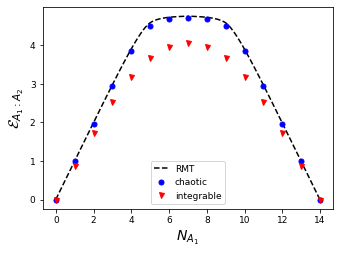

In [166]:
plt.figure(figsize=(4.8,3.6))
fsize=9
plt.rcParams.update({'font.size': fsize})

plt.plot(R12_list*Na,logneg,'k--')
plt.plot((0.5+R12_list[::-1])*Na,logneg,'k--',label='RMT')

# logneg_q_avg=np.log2(2*np.mean(neg_q,axis=1)+1)
logneg_q_avg= np.mean(neg_q,axis=1)
logneg_q0_avg= np.mean(neg_q0,axis=1)

mksize=5
midsize=int(Na/2)
plt.plot(np.arange(0,int(Na)/2), logneg_q_avg[0:midsize], 'bo', markersize=mksize,label='chaotic')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q_avg[::-1], 'bo', markersize=mksize)
# plt.plot(np.arange(0,int(Na)/2+1), neg_q, 'o')
# plt.plot(np.arange(0,int(Na)/2+1), neg_q0, 'x')

plt.plot(np.arange(0,int(Na)/2), logneg_q0_avg[0:midsize], 'ro', marker='v', markersize=mksize,label='integrable')
plt.plot(int(Na)/2+np.arange(0,int(Na)/2+1), logneg_q0_avg[::-1], 'ro',marker='v' , markersize=mksize)

# yplot= np.array([0, 0.8482, 1.2754, 1.5003, 1.5529, 1.5628, 1.5530, 1.5002, 1.2753, 0.8481, 0.0000])/np.log(2)
# yplot=[0, 0.9632, 1.8613, 2.5124, 2.6872, 2.7209, 2.6874, 2.5123, 1.8609, 0.9631, 0.0000]
# plt.plot(np.arange(0,11), yplot, 'rx',label='J')

# plt.title('$N_A$=%d' % (Na))
plt.xlabel(r'$N_{A_1}$',fontsize = fsize+5)
plt.ylabel(r'${\cal E}_{A_1:A_2}$',fontsize = fsize+6)

# plt.ylim(0,5.)
# plt.xlim(0,int(Lab)/2+1)
plt.legend(fontsize=fsize,handlelength=1.5,loc='lower center')
plt.tight_layout()
plt.savefig('figs/spin_chain_Na_%d_Nb_%d.pdf' % (Na,Nb))
plt.show()